# 損失関数

ここでは、さまざまなタスクに使用される損失関数を見ていきます。

In [1]:
import os
import json
import math
import japanize_matplotlib
import numpy as np 
import time
import copy
import requests
from io import StringIO

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
sns.set()

from tqdm import tqdm

from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        # GPUありの場合
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

def get_device():
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
    elif torch.backends.mps.is_built():
        device = torch.device("mps:0")
    else:
        device = torch.device("cpu")
    return device

In [2]:
# pytorchでデータをダウンロードするときのパス（重複してDWしないため）
DATASET_PATH = "../data"
# モデルの保存先
CHECKPOINT_PATH = "../models/06_loss_fn"
os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# 再現性のためにseedを固定する
set_seed(42)

# device情報を取得する
device = get_device()
print(f"deviceは{device}です")

deviceはmps:0です


#### 準備

0~9までの手書き数字画像のデータセットであるMNISTのデータをダウンロードします。

In [3]:
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms

# __getitem__()で取得する各画像に対して行う変換。ここではTensor化と正規化
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.13060), (0.30811),)])

# 訓練データのダウンロードとデータの分割
train_dataset = MNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# テストデータのダウンロード
test_set = MNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# DataLoaderの定義
# 実際のより大きな画像/モデルの場合はbatch_sizeはメモリに制限があり、より少なく設定されると思われます
train_loader = data.DataLoader(train_set, batch_size=1024, shuffle=True, drop_last=False)
val_loader = data.DataLoader(val_set, batch_size=1024, shuffle=False, drop_last=False)
test_loader = data.DataLoader(test_set, batch_size=1024, shuffle=False, drop_last=False)

In [4]:
# もしNormalizeの平均と標準偏差を決め打ちで0.5としない場合は、以下のように元訓練画像群から計算した平均と標準偏差を指定します
print("Mean", (train_dataset.data.float() / 255.0).mean().item())
print("Std", (train_dataset.data.float() / 255.0).std().item())

Mean 0.13066047430038452
Std 0.30810782313346863


In [5]:
# 1batchに対して各統計量を計算して確認します
# 1batchなので厳密に平均０、標準偏差１になってはないですが確認できました。
imgs, _ = next(iter(train_loader))
print(f"Mean: {imgs.mean().item():5.3f}")
print(f"Standard deviation: {imgs.std().item():5.3f}")
print(f"Maximum: {imgs.max().item():5.3f}")
print(f"Minimum: {imgs.min().item():5.3f}")

Mean: -0.001
Standard deviation: 0.998
Maximum: 2.822
Minimum: -0.424


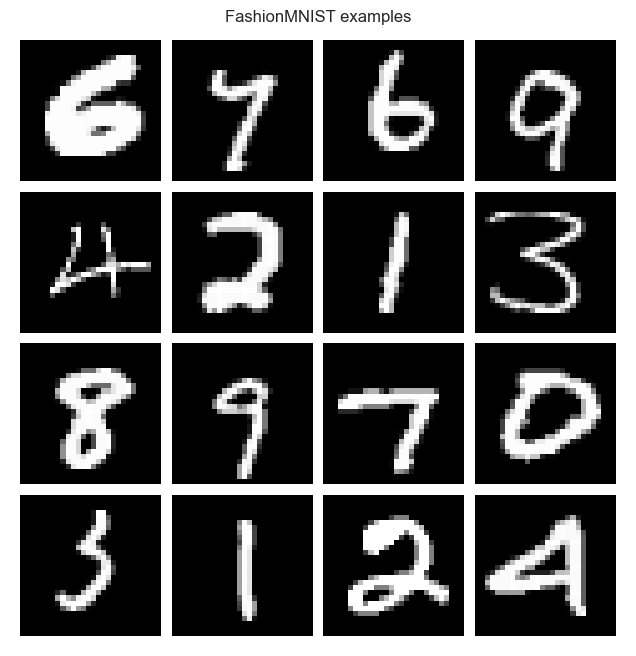

In [6]:
# ここでデータを可視化してみます
exmp_imgs = [train_set[i][0] for i in range(16)]
img_grid = torchvision.utils.make_grid(torch.stack(exmp_imgs, dim=0), nrow=4, normalize=True, pad_value=1)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("FashionMNIST examples")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

また、回帰用にBostonDatasetをダウンロードします。

In [7]:
link = r"https://raw.githubusercontent.com/eric-bunch/boston_housing/master/boston.csv"
f = requests.get(link)

df = pd.read_csv(StringIO(f.text), sep=",")
df.to_csv(f"{DATASET_PATH}/boston.csv")

**その他の関数群を定義**

In [8]:
def _get_config_file(model_path, model_name):
    return os.path.join(model_path, model_name + ".config")

def _get_model_file(model_path, model_name):
    return os.path.join(model_path, model_name + ".tar")

def _get_result_file(model_path, model_name):
    return os.path.join(model_path, model_name + "_results.json")

def load_model(model_path, model_name, net=None, base=None):
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    assert os.path.isfile(config_file), f"Could not find the config file \"{config_file}\". Are you sure this is the correct path and you have your model config stored here?"
    assert os.path.isfile(model_file), f"Could not find the model file \"{model_file}\". Are you sure this is the correct path and you have your model stored here?"
    with open(config_file, "r") as f:
        config_dict = json.load(f)
    if net is None:
        net = base(**config_dict)
    net.load_state_dict(torch.load(model_file))
    return net
    
def save_model(model, model_path, model_name):
    config_dict = model.config
    os.makedirs(model_path, exist_ok=True)
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    with open(config_file, "w") as f:
        json.dump(config_dict, f)
    torch.save(model.state_dict(), model_file)

## 回帰

まずは回帰分析を行います。

**dataloaderの準備**

In [9]:
df_boston = pd.read_csv(f"{DATASET_PATH}/boston.csv", index_col=0)

# Xとyに分割
y_column = ["MDEV"]
X_columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT']
X = df_boston[X_columns]
y = df_boston[y_column]

# TensorDatasetの作成
X = torch.tensor(X.values, dtype=torch.float32)
y = torch.tensor(y.values, dtype=torch.float32)
dataset = data.TensorDataset(X, y)

# trainとval, testに分割
n_train = int(len(dataset) * 0.7)
n_val = int(len(dataset) * 0.2)
n_test = len(dataset) - n_train - n_val
train_set, val_set, test_set = data.random_split(dataset, [n_train, n_val, n_test])

# dataloaderの作成
train_loader = data.DataLoader(train_set, 64, shuffle=True, drop_last=False)
val_loader = data.DataLoader(val_set, n_val, shuffle=True, drop_last=False)
test_loader = data.DataLoader(test_set, n_test, shuffle=True, drop_last=False)


**訓練するときの関数を定義**

In [10]:
def train_model(net, model_name, loss_module, max_epochs=100, batch_size=64,  patience=7):

    # Defining optimizer, loss and data loader
    optimizer = torch.optim.SGD(net.parameters(), lr=1e-2, momentum=0.9)
    train_loader_local = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)

    results = None
    val_scores = []
    train_losses  = []
    best_val_epoch = -1
    for epoch in range(max_epochs):
        ############
        # Training #
        ############
        net.train()
        epoch_loss = 0.0
        t = tqdm(train_loader_local, leave=False)
        for x, y in t:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            preds = net(x)
            loss = loss_module(preds, y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        epoch_loss /= len(train_loader_local)
        train_losses.append(epoch_loss)

        ##############
        # Validation #
        ##############
        val_score = test_model(net, val_loader)
        val_scores.append(val_score)
        
        #print(f"[Epoch {epoch+1:2d}] Training Score: {epoch_loss:05.5f}, Validation Score: {val_score:05.5f}")

        if len(val_scores) == 1 or val_score < val_scores[best_val_epoch]:
            best_val_epoch = epoch
        elif best_val_epoch <= epoch - patience:
            print(f"Early stopping due to no improvement over the last {patience} epochs")
            break

    test_score = test_model(net, test_loader)
    results = {"test_score": test_score, "val_scores": val_scores, "train_losses": train_losses}
            
    # Plot a curve of the validation accuracy
    sns.set()
    plt.plot([i for i in range(1,len(results["train_losses"])+1)], results["train_losses"], label="Train")
    plt.plot([i for i in range(1,len(results["val_scores"])+1)], results["val_scores"], label="Val")
    plt.xlabel("Epochs")
    plt.ylabel("Validation Score")
    plt.ylim(0, 1000)
    #plt.ylim(min(results["val_scores"]), max(results["train_losses"])*1.01)
    plt.title(f"Validation performance of {model_name}")
    plt.legend()
    plt.show()
    plt.close()

    return results

def test_model(net, data_loader):
    """
    Test a model on a specified dataset.
    
    Inputs:
        net - Trained model of type BaseNetwork
        data_loader - DataLoader object of the dataset to test on (validation or test)
    """
    net.eval()
    
    test_score = 0.0
    for x, y in data_loader:
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            preds = net(x)
            mse = mean_squared_error(y.cpu().numpy(), preds.cpu().numpy())
            test_score += mse
    test_score /= len(data_loader)
            
    return test_score

**ネットワークの定義**

Bostonデータセットでは各特徴量ごとに単位が異なるので、入力層の後にBatchNormalizationを入れてスケールを統一しています。（普通に訓練データ全体で正規化したものを入力した方がいいかもしれませんが、今回は無理矢理内容に入れたかったので。。） 

BatchNormalizationは名前の通り、ミニバッチ内の全サンプルに対して特徴量ごとに正規化（平均が0, 分散が1になるように変換）する層になります。ただ、普通の正規化ではなく以下のように$\beta$, $\gamma$という学習されるパラメータがあります。また、推論時は平均や分散を計算できないので、学習時に計算された平均と分散の移動平均を用います。そのため、引数として``momentum``を持っています。バッチ正規化は多層NNを安定させたり有効な層ですが、なぜうまくいくのかははっきり分かっていないそうです。また、学習時と推論時で平均と分散に大きな差がある場合は悪影響を与える可能性があります。

$$
\hat{u}_j = \gamma_i \frac{u_j - \mu_j}{\sqrt{\sigma^2_j + \epsilon}} + \beta_j
$$

また、正則化の１種であるDropoutも入れてあります。Dropoutはネットワーク内のユニットを学習時のみランダムに削除する方法です。学習時はミニバッチ単位で確率pでランダムに選出したユニットを無効化します。推論時は学習時に比べユニット数が$\frac{1}{1-p}$倍増えているので、出力を$1-p$倍します。これは、推論時にDropout層が単に恒等関数を計算することを意味しています。このDropoutは、オーバーフィッティングを避ける効果や擬似的なアンサンブルの効果があることが知られています。また、全結合層だけでなく、入力層など様々な層の後に使用されます。

最後に、今回は出力層に恒等関数（何も設定してない）を考えましたが、yの値域が[-1:1]の場合は双曲線正接関数を選ぶなど目的とする出力域が得られるように設計します。

In [14]:
class Dropout(nn.Module):
    pass

In [ ]:
class MSELoss(nn.Module):
    pass

In [11]:
class RegressionNet(nn.Module):
    
    def __init__(self, act_fn=nn.ReLU, input_size=784, output_size=1, hidden_sizes=[512, 256, 256, 128]):
        """
        Inputs:
            act_fn - 今回試したい活性化関数
            input_size - 画像のサイズ
            num_classes - 予測したいクラス数
            hidden_sizes - 隠れ層のサイズのリスト
        """
        super().__init__()
        
        layers = []
        layer_sizes = [input_size] + hidden_sizes
        layers.append(nn.BatchNorm1d(input_size))
        for layer_index in range(1, len(layer_sizes)):
            layers += [nn.Linear(layer_sizes[layer_index-1], layer_sizes[layer_index]),
                       #nn.BatchNorm1d(layer_sizes[layer_index]),
                       act_fn(),
                       nn.Dropout(p=0.25)]
        layers += [nn.Linear(layer_sizes[-1], output_size)]
        # リスト情報からlayerを追加
        self.layers = nn.Sequential(*layers)
        
        # モデルを保存/読み込む際に必要な情報を格納
        self.config = {"input_size": input_size, "output_size": output_size, "hidden_sizes": hidden_sizes} 
        
    def forward(self, x):
        out = self.layers(x)
        return out    

In [12]:
model = RegressionNet(input_size=len(X_columns), hidden_sizes=[5, 5])
model.to(device)

RegressionNet(
  (layers): Sequential(
    (0): BatchNorm1d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=13, out_features=5, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=5, out_features=5, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.25, inplace=False)
    (7): Linear(in_features=5, out_features=1, bias=True)
  )
)

以下の結果を見ると、訓練とバリデーションのロスを比較すると、バリデーションの方が良くなってしまっていることが確認できます。  
たまにおきますが、以下のような理由が考えられます。今回の理由としては２か３ですかね？３はランダムに分割はしていますが、検証用データのデータ数がそこまで多くないのと、２は複雑なタスクではないので、学習中に大きく性能が変わっている可能性があります。また、バグやリークの可能性もありますが、テストデータのMSEも71とほとんど同じなのでその可能性は低そうです。
1. dropoutなど訓練時のみ適用されているものがある
2. Training Lossは1エポックをかけて計算され、Validation Lossは1エポック終了時に計算される
3. バリデーションデータに、訓練データより簡単なデータが集まっている

https://masamunetogetoge.com/val-loss

Early stopping due to no improvement over the last 7 epochs


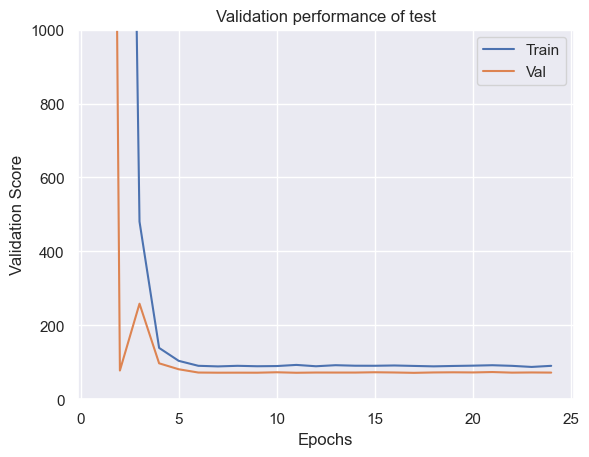

70.60136413574219


In [13]:
results = train_model(model, "test", loss_module=nn.MSELoss(), batch_size=20, max_epochs=100)
print(results["test_score"])

## 2値分類

## 多クラス分類

## 順序回帰

## マルチインプット

## マルチタスク


以上で損失関数は終わりです。  
ここまでで深層学習第2版の1-4章はカバーできたのではないでしょうか。次は画像系を見ていきたいと思います。